In [9]:
import pandas as pd
import numpy as np
import shap
from sklearn import set_config
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
path = "https://raw.githubusercontent.com/sharmaroshan/Churn-Modelling-Dataset/master/Churn_Modelling.csv"

In [10]:
# set config

set_config(transform_output="pandas")

In [11]:
# load the data

df = pd.read_csv(path)

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [12]:
# shape of the data

df.shape

(10000, 14)

In [13]:
# check for missing values

df.isna().sum()

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


In [14]:
# check for duplicates

df.duplicated().sum()

np.int64(0)

# EDA

In [15]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [16]:
# drop the first three columns

columns_to_drop = df.columns[0:3]

columns_to_drop

Index(['RowNumber', 'CustomerId', 'Surname'], dtype='object')

In [17]:
# drop the columns

df.drop(columns=columns_to_drop, inplace=True)

In [18]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [19]:
# lowercase the column names

df.rename(columns=str.lower, inplace=True)

In [20]:
df.columns

Index(['creditscore', 'geography', 'gender', 'age', 'tenure', 'balance',
       'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary',
       'exited'],
      dtype='object')

In [21]:
# make our X and y

X = df.drop(columns=["exited"])

y = df["exited"]

In [22]:
X

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77
9997,709,France,Female,36,7,0.00,1,0,1,42085.58
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52


In [23]:
y

,exited
0,1
1,0
2,1
3,0
4,0
...,...
9995,0
9996,0
9997,1
9998,1


In [24]:
# datatype

df.dtypes

,0
creditscore,int64
geography,object
gender,object
age,int64
tenure,int64
balance,float64
numofproducts,int64
hascrcard,int64
isactivemember,int64
estimatedsalary,float64


In [25]:
# list of columns

numerical_cols = ["creditscore", "age", "balance", "estimatedsalary"]

categorical_cols = ["gender", "geography"]

In [26]:
numerical_cols

['creditscore', 'age', 'balance', 'estimatedsalary']

In [27]:
remainder_cols = [column_name for column_name in X.columns if column_name not in numerical_cols + categorical_cols]

remainder_cols

['tenure', 'numofproducts', 'hascrcard', 'isactivemember']

In [28]:
df[numerical_cols]

,creditscore,age,balance,estimatedsalary
0,619,42,0.00,101348.88
1,608,41,83807.86,112542.58
2,502,42,159660.80,113931.57
3,699,39,0.00,93826.63
4,850,43,125510.82,79084.10
...,...,...,...,...
9995,771,39,0.00,96270.64
9996,516,35,57369.61,101699.77
9997,709,36,0.00,42085.58
9998,772,42,75075.31,92888.52


In [29]:
df[categorical_cols]

,gender,geography
0,Female,France
1,Female,Spain
2,Female,France
3,Female,France
4,Female,Spain
...,...,...
9995,Male,France
9996,Male,France
9997,Female,France
9998,Male,Germany


In [30]:
df[remainder_cols]

,tenure,numofproducts,hascrcard,isactivemember
0,2,1,1,1
1,1,1,0,1
2,8,3,1,0
3,1,2,0,0
4,2,1,1,1
...,...,...,...,...
9995,5,2,1,0
9996,10,1,1,1
9997,7,1,0,1
9998,3,2,1,0


In [31]:
from matplotlib.gridspec import GridSpec

In [32]:
def plots_for_numerical_columns(column_name, bins, kde=True):
    # set the figure size
    fig = plt.figure(figsize=(8,6))
    # gridspec
    grid = GridSpec(nrows=2, ncols=2, height_ratios=[0.6,0.4])

    # define the axes
    ax1 = plt.subplot(grid[0,:])
    ax2 = plt.subplot(grid[1,:])

    # plot the histogram
    sns.histplot(data=X, x=column_name, bins=bins, kde=kde, ax=ax1)

    # plot the boxplot
    sns.boxplot(data=df,x=column_name,ax=ax2)

    plt.show()

In [33]:
# bins for the histogram

col_bins = {
    column_name:bin_val for column_name, bin_val in zip(numerical_cols, [50,15,"auto","auto"])
}

col_bins

{'creditscore': 50, 'age': 15, 'balance': 'auto', 'estimatedsalary': 'auto'}

Creditscore



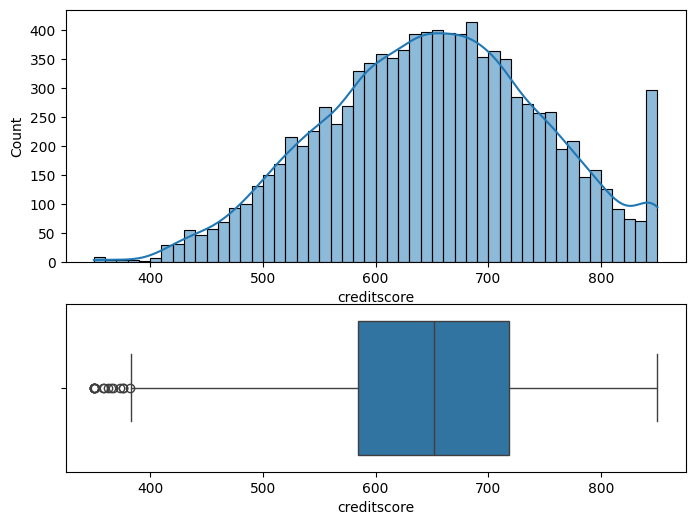




Age



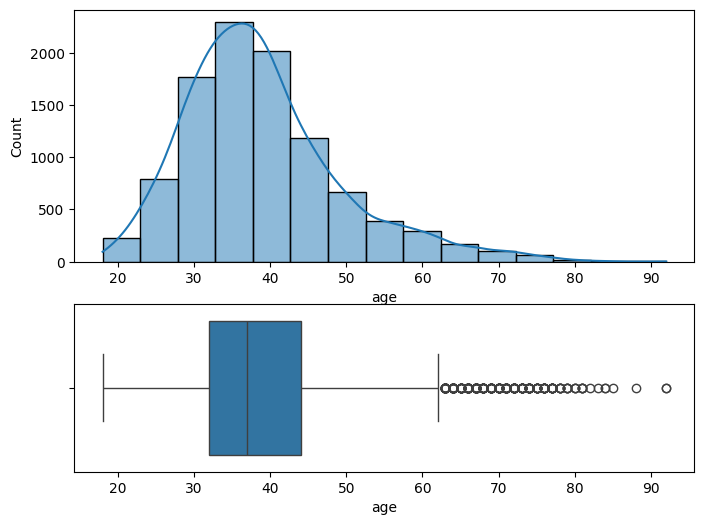




Balance



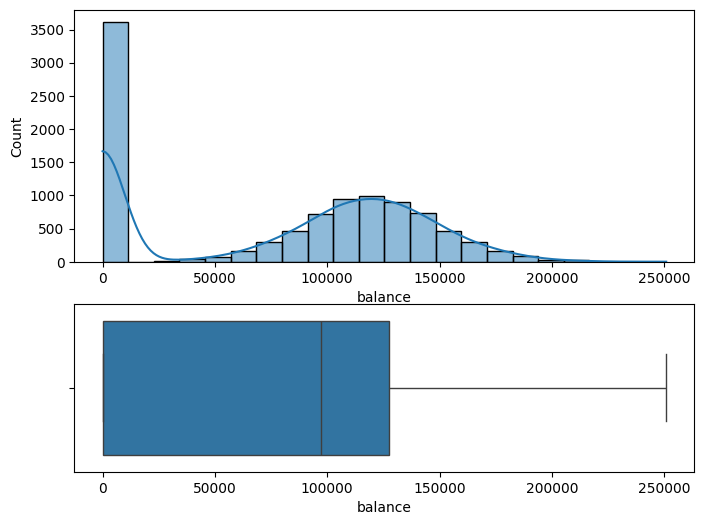




Estimatedsalary



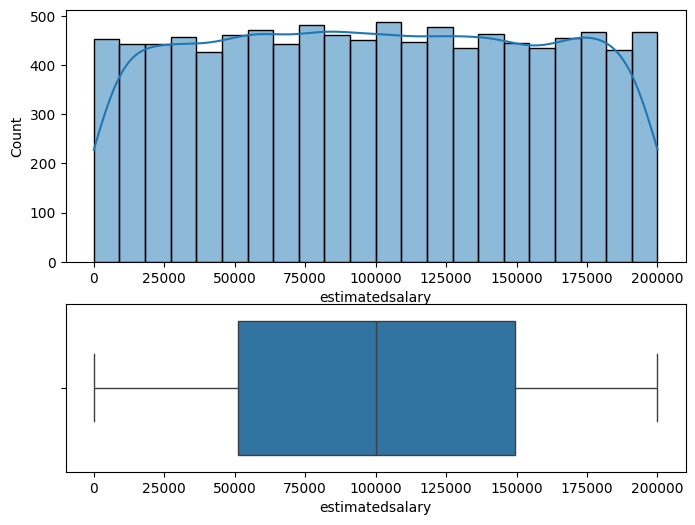

In [34]:
for num_col in numerical_cols:
    print(f"{num_col.title()}", end="\n\n")
    plots_for_numerical_columns(column_name=num_col, bins=col_bins[num_col])
    print("\n\n")

In [35]:
# people with 0 bal

(
    X.loc[
        (X["balance"].eq(0)), :
    ]
)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
0,619,France,Female,42,2,0.0,1,1,1,101348.88
3,699,France,Female,39,1,0.0,2,0,0,93826.63
6,822,France,Male,50,7,0.0,2,1,1,10062.80
11,497,Spain,Male,24,3,0.0,2,1,0,76390.01
12,476,France,Female,34,10,0.0,2,1,0,26260.98
...,...,...,...,...,...,...,...,...,...,...
9989,841,Spain,Male,28,4,0.0,2,1,1,179436.60
9992,726,Spain,Male,36,2,0.0,1,1,0,195192.40
9994,800,France,Female,29,2,0.0,2,0,0,167773.55
9995,771,France,Male,39,5,0.0,2,1,0,96270.64


In [36]:
X["balance"].eq(0)

,balance
0,True
1,False
2,False
3,True
4,False
...,...
9995,True
9996,False
9997,True
9998,False


In [37]:
# new col for 0 bal customers

X["iszerobal"] = X["balance"].eq(0).astype(int)

In [38]:
X

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,iszerobal
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,1
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,1
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,0


In [39]:
def plots_for_categorical_cols(column_name):
    display(X[column_name].value_counts(normalize=True))
    print(f"There are {X[column_name].nunique()} unique values in the column {column_name} which are {X[column_name].unique()}")
    # plot the count plot
    sns.countplot(data=X,x=column_name)
    plt.show()

Gender


,proportion
gender,
Male,0.5457
Female,0.4543


There are 2 unique values in the column gender which are ['Female' 'Male']


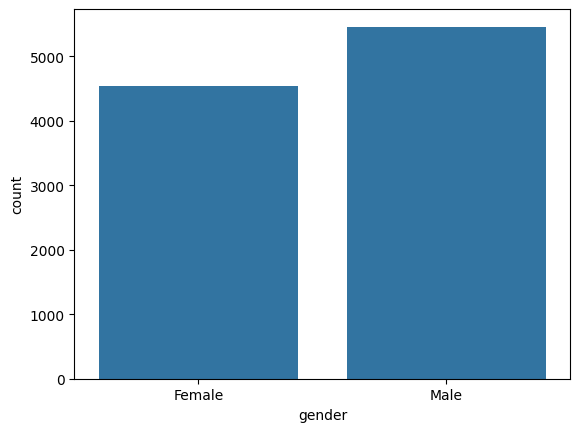




Geography


,proportion
geography,
France,0.5014
Germany,0.2509
Spain,0.2477


There are 3 unique values in the column geography which are ['France' 'Spain' 'Germany']


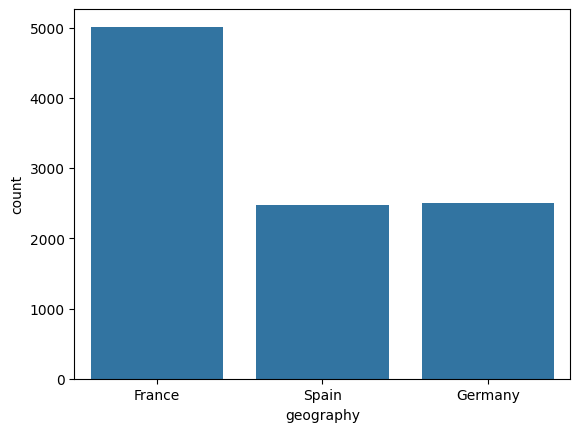

In [40]:
for cat_col in categorical_cols:
    print(f"{cat_col.title()}")
    plots_for_categorical_cols(cat_col)
    print("\n\n")

In [41]:
X

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,iszerobal
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,1
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,1
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,0


In [42]:
# distribution of target

y.value_counts(normalize=True)

,proportion
exited,
0,0.7963
1,0.2037


# FE and Model training

In [43]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [44]:
# split the data

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=30,stratify=y)

In [45]:
print(f"The shape of training data is {X_train.shape}")
print(f"The shape of test data is {X_test.shape}")

The shape of training data is (8000, 11)
The shape of test data is (2000, 11)


In [46]:
# column transformer

scaler = MinMaxScaler()

encoder = OneHotEncoder(handle_unknown="ignore",sparse_output=False)

preprocessor = ColumnTransformer(transformers=[
    ("scaler",scaler,numerical_cols),
    ("encoder",encoder,categorical_cols)
], remainder="passthrough",verbose_feature_names_out=False)

In [47]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', MinMaxScaler(),
                                 ['creditscore', 'age', 'balance',
                                  'estimatedsalary']),
                                ('encoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['gender', 'geography'])],
                  verbose_feature_names_out=False)

In [48]:
# apply the transformation

X_train = preprocessor.fit_transform(X_train)

X_test = preprocessor.transform(X_test)

In [49]:
X_train

,creditscore,age,balance,estimatedsalary,gender_Female,gender_Male,geography_France,geography_Germany,geography_Spain,tenure,numofproducts,hascrcard,isactivemember,iszerobal
3491,0.440,0.229730,0.341448,0.527619,0.0,1.0,0.0,1.0,0.0,6,1,1,0,0
3479,0.236,0.378378,0.364466,0.054738,0.0,1.0,1.0,0.0,0.0,7,1,1,0,0
5098,0.400,0.148649,0.579096,0.737433,0.0,1.0,0.0,1.0,0.0,9,2,1,0,0
5370,0.664,0.310811,0.000000,0.670797,0.0,1.0,1.0,0.0,0.0,6,2,0,1,1
7763,0.528,0.243243,0.175589,0.366623,1.0,0.0,0.0,0.0,1.0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5030,0.424,0.202703,0.369310,0.006714,0.0,1.0,0.0,1.0,0.0,8,2,1,0,0
9619,0.668,0.229730,0.398440,0.884437,0.0,1.0,0.0,1.0,0.0,3,1,1,1,0
5972,0.396,0.418919,0.432199,0.635117,0.0,1.0,0.0,1.0,0.0,9,1,0,0,0
3160,0.482,0.135135,0.000000,0.243000,0.0,1.0,1.0,0.0,0.0,5,2,1,1,1


In [50]:
X_test

,creditscore,age,balance,estimatedsalary,gender_Female,gender_Male,geography_France,geography_Germany,geography_Spain,tenure,numofproducts,hascrcard,isactivemember,iszerobal
2576,0.590,0.243243,0.238718,0.219961,0.0,1.0,0.0,0.0,1.0,4,2,1,0,0
5875,0.324,0.202703,0.484999,0.418392,1.0,0.0,1.0,0.0,0.0,6,2,1,1,0
7668,0.352,0.581081,0.533465,0.225868,0.0,1.0,0.0,1.0,0.0,6,2,1,1,0
2560,0.600,0.162162,0.000000,0.339960,1.0,0.0,0.0,0.0,1.0,6,1,0,0,1
1775,0.398,0.270270,0.427598,0.787231,1.0,0.0,1.0,0.0,0.0,8,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3022,0.596,0.121622,0.000000,0.815322,1.0,0.0,0.0,0.0,1.0,7,2,1,1,1
8256,0.642,0.540541,0.712297,0.108794,0.0,1.0,0.0,0.0,1.0,1,1,1,1,0
5436,0.962,0.216216,0.000000,0.829226,1.0,0.0,1.0,0.0,0.0,2,2,0,0,1
3063,0.518,0.189189,0.286460,0.759639,0.0,1.0,1.0,0.0,0.0,7,1,1,1,0


**Model Building**

In [51]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [52]:
from sklearn.ensemble import VotingClassifier

In [53]:
# define models

rf = RandomForestClassifier(class_weight="balanced", random_state=42)

xgb = XGBClassifier(class_weight="balanced", random_state=42)

lgbm = LGBMClassifier(class_weight="balanced", random_state=42)

In [54]:
# build a voting classifier

model = VotingClassifier(estimators=[
    ("rf",rf),
    ("xgb",xgb),
    ("lgbm",lgbm)
], voting="soft",n_jobs=-1)

model

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            class_weight='balanced',
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None, ...)),
                             ('lgbm',
                              LGBMClassifier(class_weight='balanced',
                                             random_state=42))],
                 n_jobs=-1, voting='soft')

In [55]:
# fit the model on the dataset

model.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            class_weight='balanced',
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None, ...)),
                             ('lgbm',
                              LGBMClassifier(class_weight='balanced',
                                             random_state=42))],
                 n_jobs=-1, voting='soft')

In [56]:
# get the predictions

y_pred = model.predict(X_test)

In [57]:
model.predict_proba(X_test.iloc[0:5,:])

array([[0.82271011, 0.17728989],
       [0.93954485, 0.06045516],
       [0.76438537, 0.23561462],
       [0.66366983, 0.33633016],
       [0.64972961, 0.3502704 ]])

In [58]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1593
           1       0.71      0.57      0.63       407

    accuracy                           0.86      2000
   macro avg       0.80      0.75      0.77      2000
weighted avg       0.86      0.86      0.86      2000



**HP Tuning**

In [60]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 2.7 MB/s eta 0:00:00


In [61]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [62]:
model

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            class_weight='balanced',
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None, ...)),
                             ('lgbm',
                              LGBMClassifier(class_weight='balanced',
                                             random_state=42))],
                 n_jobs=-1, voting='soft')

In [63]:
model.estimators

[('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
 ('xgb',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                class_weight='balanced', colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, feature_weights=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None, ...)),
 ('lgbm', LGBMClassifier(class_weight='balanced', random_state=42))]

In [64]:
def objective(trial: optuna.Trial):

    params_dict = {
        "rf__n_estimators": trial.suggest_int("rf__n_estimators", 50, 200),
        "rf__max_depth": trial.suggest_int("rf__max_depth", 5, 12),
        "rf__max_samples": trial.suggest_float("rf__max_samples", 0.5, 1.0),
        "xgb__learning_rate": trial.suggest_float("xgb__learning_rate", 0.01, 0.5),
        "xgb__max_depth": trial.suggest_int("xgb__max_depth", 5, 15),
        "xgb__n_estimators": trial.suggest_int("xgb__n_estimators", 30, 200),
        "xgb__subsample": trial.suggest_float("xgb__subsample", 0.5,1.0),
        "xgb__colsample_bynode": trial.suggest_float("xgb__colsample_bynode", 0.7, 1.0),
        "xgb__reg_lambda": trial.suggest_float("xgb__reg_lambda",0.1,10.0),
        "lgbm__max_depth": trial.suggest_int("lgbm__max_depth", 5, 15),
        "lgbm__n_estimators": trial.suggest_int("lgbm__n_estimators", 30, 200),
        "lgbm__learning_rate": trial.suggest_float("lgbm__learning_rate", 0.01, 0.5),
        "lgbm__subsample": trial.suggest_float("lgbm__subsample", 0.5,1.0),
        "lgbm__reg_lambda": trial.suggest_float("lgbm__reg_lambda",0.1,10.0)
    }

    # define models
    rf = RandomForestClassifier(class_weight="balanced", random_state=42)
    xgb = XGBClassifier(class_weight="balanced", random_state=42)
    lgbm = LGBMClassifier(class_weight="balanced", random_state=42)

    # build a voting classifier
    model = VotingClassifier(estimators=[
        ("rf",rf),
        ("xgb",xgb),
        ("lgbm",lgbm)
    ], voting="soft",n_jobs=-1)

    # pass parameters to model
    model.set_params(**params_dict)

    # cross validation
    scores = cross_val_score(estimator=model,
                             X=X_train, y=y_train,
                             scoring="f1",
                             cv=StratifiedKFold(n_splits=5,random_state=10,shuffle=True),
                             n_jobs=-1)

    # mean f1
    mean_f1 = np.mean(scores)

    return mean_f1

In [65]:
# define my study

study = optuna.create_study(direction="maximize")

study.optimize(func=objective,n_trials=20,n_jobs=-1,show_progress_bar=True)

[I 2026-02-06 14:30:05,286] A new study created in memory with name: no-name-fdc6a68a-e09f-4725-94c8-f1f69001089c


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2026-02-06 14:30:24,554] Trial 1 finished with value: 0.6005765867989247 and parameters: {'rf__n_estimators': 97, 'rf__max_depth': 7, 'rf__max_samples': 0.8114135200133135, 'xgb__learning_rate': 0.3127940909610893, 'xgb__max_depth': 15, 'xgb__n_estimators': 30, 'xgb__subsample': 0.6439572081561907, 'xgb__colsample_bynode': 0.9745825491488449, 'xgb__reg_lambda': 6.107919847106941, 'lgbm__max_depth': 12, 'lgbm__n_estimators': 70, 'lgbm__learning_rate': 0.37848567921869986, 'lgbm__subsample': 0.6986299037732306, 'lgbm__reg_lambda': 1.0342182008219627}. Best is trial 1 with value: 0.6005765867989247.
[I 2026-02-06 14:30:25,126] Trial 0 finished with value: 0.5948163253658791 and parameters: {'rf__n_estimators': 134, 'rf__max_depth': 11, 'rf__max_samples': 0.7590667944465832, 'xgb__learning_rate': 0.41807511413428755, 'xgb__max_depth': 12, 'xgb__n_estimators': 176, 'xgb__subsample': 0.8500186449715235, 'xgb__colsample_bynode': 0.724858756513195, 'xgb__reg_lambda': 8.018774573745, 'lgbm__

In [66]:
# best parameters

study.best_params

{'rf__n_estimators': 178,
 'rf__max_depth': 5,
 'rf__max_samples': 0.6631180377374011,
 'xgb__learning_rate': 0.014447145258374145,
 'xgb__max_depth': 8,
 'xgb__n_estimators': 114,
 'xgb__subsample': 0.7273941642955932,
 'xgb__colsample_bynode': 0.9071704646624661,
 'xgb__reg_lambda': 3.6009475045587616,
 'lgbm__max_depth': 15,
 'lgbm__n_estimators': 31,
 'lgbm__learning_rate': 0.3366662975365448,
 'lgbm__subsample': 0.8858125503119769,
 'lgbm__reg_lambda': 7.482678872798443}

In [67]:
best_params = study.best_params

In [68]:
# best score
study.best_value


0.6212997535499885

In [69]:
# define models
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
xgb = XGBClassifier(class_weight="balanced", random_state=42)
lgbm = LGBMClassifier(class_weight="balanced", random_state=42)

# build a voting classifier
model = VotingClassifier(estimators=[
    ("rf",rf),
    ("xgb",xgb),
    ("lgbm",lgbm)
], voting="soft",n_jobs=-1)

# pass the best params to model
model.set_params(**best_params)

model

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=5,
                                                     max_samples=0.6631180377374011,
                                                     n_estimators=178,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            class_weight='balanced',
                                            colsample_bylevel=None,
                                            colsample_bynode=0.9071704646624661,
                                            colsample_bytree=None, device=None,
                                            early_st...
                                            max_delta_step=None, max_depth=8,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=114, n_jobs=None, ...)),
                             ('lgbm',
                              LGBMClassifier(class_weight='balanced',
                                             learning_rate=0.3366662975365448,
                                             max_depth=15, n_estimators=31,
                                             random_state=42,
                                             reg_lambda=7.482678872798443,
                                             subsample=0.8858125503119769))],
                 n_jobs=-1, voting='soft')

In [70]:
# train the model

model.fit(X_train,y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=5,
                                                     max_samples=0.6631180377374011,
                                                     n_estimators=178,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            class_weight='balanced',
                                            colsample_bylevel=None,
                                            colsample_bynode=0.9071704646624661,
                                            colsample_bytree=None, device=None,
                                            early_st...
                                            max_delta_step=None, max_depth=8,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=114, n_jobs=None, ...)),
                             ('lgbm',
                              LGBMClassifier(class_weight='balanced',
                                             learning_rate=0.3366662975365448,
                                             max_depth=15, n_estimators=31,
                                             random_state=42,
                                             reg_lambda=7.482678872798443,
                                             subsample=0.8858125503119769))],
                 n_jobs=-1, voting='soft')

In [71]:
# get the predictions
y_pred = model.predict(X_test)

In [72]:
model.predict_proba(X_test.iloc[0:3, :])

array([[0.80190941, 0.19809058],
       [0.7948976 , 0.20510241],
       [0.53657331, 0.46342669]])

In [73]:
# classification report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1593
           1       0.64      0.64      0.64       407

    accuracy                           0.85      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.85      0.85      0.85      2000



# SHAP

In [75]:
model

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=5,
                                                     max_samples=0.6631180377374011,
                                                     n_estimators=178,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            class_weight='balanced',
                                            colsample_bylevel=None,
                                            colsample_bynode=0.9071704646624661,
                                            colsample_bytree=None, device=None,
                                            early_st...
                                            max_delta_step=None, max_depth=8,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=114, n_jobs=None, ...)),
                             ('lgbm',
                              LGBMClassifier(class_weight='balanced',
                                             learning_rate=0.3366662975365448,
                                             max_depth=15, n_estimators=31,
                                             random_state=42,
                                             reg_lambda=7.482678872798443,
                                             subsample=0.8858125503119769))],
                 n_jobs=-1, voting='soft')

In [76]:
model.predict_proba(X_test.iloc[0:3])[:,1]

array([0.19809058, 0.20510241, 0.46342669])

In [77]:
def prediction_fn(X):
    predictions = model.predict_proba(X)[:,1]
    return predictions

In [78]:
# model agnostic explainer

explainer = shap.Explainer(model=prediction_fn,
                           masker=X_train,
                           link=shap.links.identity)

In [79]:
X_train.shape[1]

14

In [80]:
# calculate the shap values

shap_values = explainer(X_test.iloc[[1],:])

shap_values

.values =
array([[ 2.03395874e-02, -9.10752122e-02,  4.54946797e-02,
        -1.33152222e-02,  2.77061434e-02,  6.92341597e-03,
        -2.30666363e-03, -2.08297147e-02,  7.39489846e-04,
         3.72853205e-03, -5.40987674e-02,  4.02525354e-05,
        -2.39554206e-02,  7.21866453e-03]])

.base_values =
array([0.29849265])

.data =
array([[0.324     , 0.2027027 , 0.48499895, 0.41839191, 1.        ,
        0.        , 1.        , 0.        , 0.        , 6.        ,
        2.        , 1.        , 1.        , 0.        ]])

In [81]:
shap_values.shape

(1, 14)

In [82]:
model.predict_proba(X_test.iloc[[1],:])[:,1]

array([0.20510241])

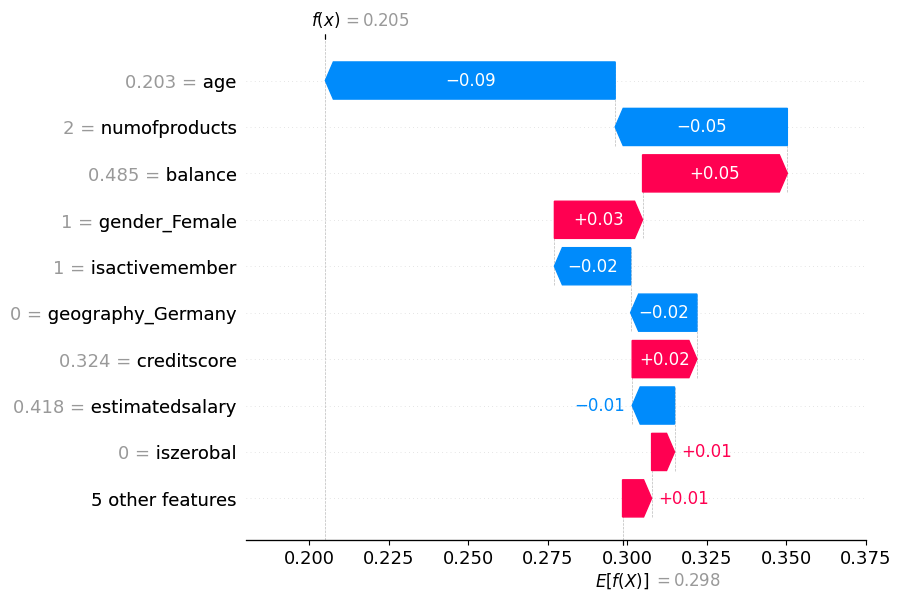

In [83]:
shap.plots.waterfall(shap_values[0])

In [84]:
X_train.shape

(8000, 14)

In [85]:
X_test.shape

(2000, 14)

In [86]:
# sample 500 rows from test data

test_data_sample = X_test.sample(500)

In [87]:
test_data_sample.shape

(500, 14)

In [88]:
# calculate shap values for the entire test data

shap_values = explainer(test_data_sample)

PermutationExplainer explainer: 501it [08:06,  1.02it/s]


In [89]:
shap_values.shape

(500, 14)

In [90]:
shap_values

.values =
array([[ 2.08850319e-02,  1.63147574e-01,  2.44559454e-02, ...,
         3.14286183e-03,  5.56889594e-02,  1.04780282e-02],
       [ 2.13890222e-04,  4.45369292e-02, -3.71167502e-02, ...,
        -4.93285827e-04, -9.37880195e-02, -1.60963784e-02],
       [ 9.36755062e-03, -6.16733315e-02,  2.70074719e-02, ...,
         1.81536888e-03,  7.17031523e-02,  3.48490840e-03],
       ...,
       [ 2.78731658e-03, -5.58688338e-02, -4.22610342e-02, ...,
        -3.46515785e-04,  3.93163918e-02, -1.48610998e-02],
       [ 7.87281471e-04, -9.42960327e-02, -2.80146632e-02, ...,
         1.45207970e-03, -3.88628301e-02,  3.38260385e-03],
       [ 2.75799455e-03, -1.20406985e-01, -2.41174186e-02, ...,
         5.99013545e-05,  3.36643516e-02,  8.02672148e-03]])

.base_values =
array([0.29849265, 0.29849265, 0.29849265, 0.29849265, 0.29849265,
       0.29849265, 0.29849265, 0.29849265, 0.29849265, 0.29849265,
       0.29849265, 0.29849265, 0.29849265, 0.29849265, 0.29849265,
       0.2984926

**Global Plots**

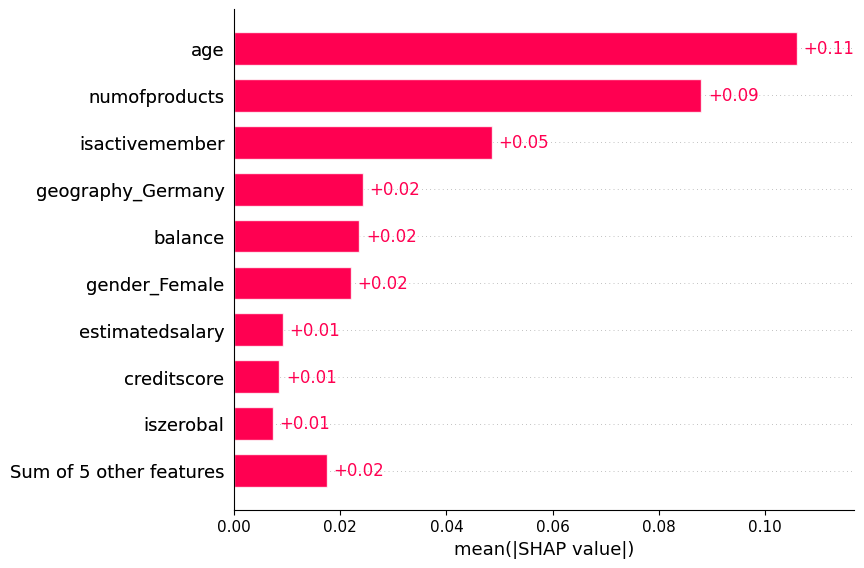

In [91]:
# bar plot

shap.plots.bar(shap_values)

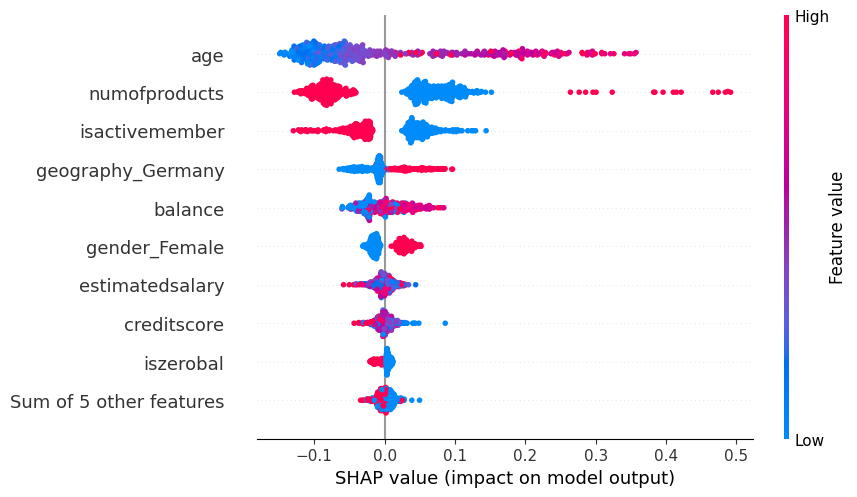

In [92]:
# summary plot

shap.plots.beeswarm(shap_values)

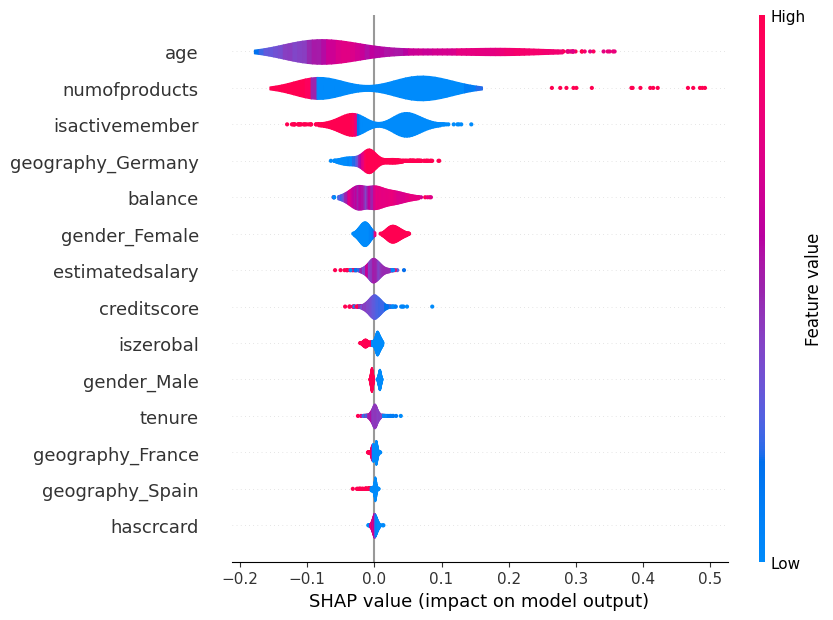

In [93]:
# violin plot

shap.plots.violin(shap_values)

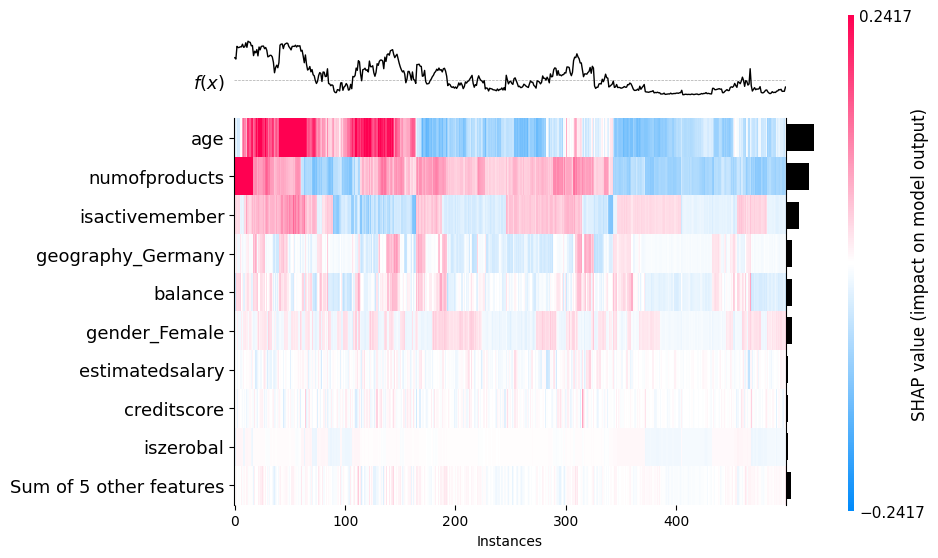

<Axes: xlabel='Instances'>

In [94]:
# heatmap plot

shap.plots.heatmap(shap_values)

**Local Plots**

In [95]:
test_case = X_test[y_test == 1].sample(1)

row_shap_values = explainer(test_case)[0]

In [96]:
row_shap_values.shape

(14,)

In [97]:
df.loc[test_case.index]

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
70,738,Germany,Male,58,2,133745.44,4,1,0,28373.86,1


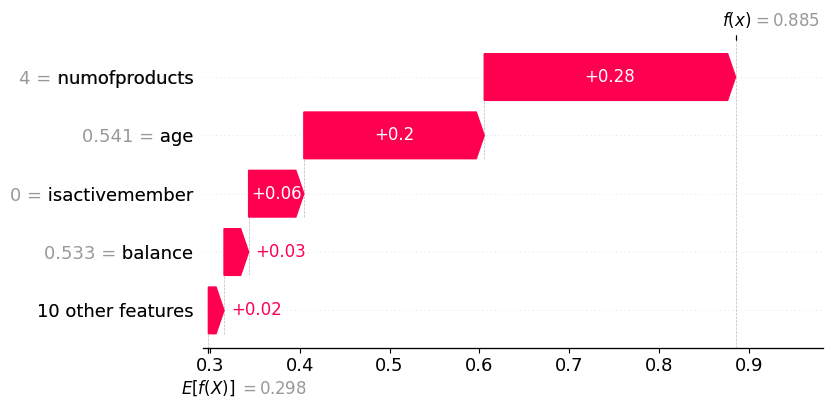

In [98]:
# waterfall plot

shap.plots.waterfall(row_shap_values, max_display=5)

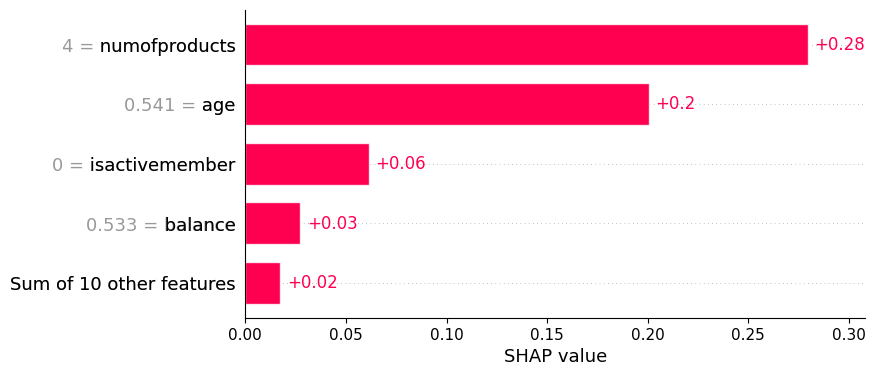

In [99]:
# bar plot--> local

shap.plots.bar(row_shap_values, max_display=5)

In [100]:
# row force plot

shap.initjs()

shap.plots.force(row_shap_values)

In [101]:
row_shap_values

.values =
array([ 1.20035502e-03,  2.00654472e-01,  2.73552140e-02,  1.95348101e-04,
       -8.66705296e-03, -3.37503698e-03,  2.87387967e-03,  1.54551817e-02,
        8.60634412e-04,  1.50435218e-04,  2.79543438e-01,  1.05965752e-04,
        6.14199753e-02,  8.60906380e-03])

.base_values =
np.float64(0.29849265013668125)

.data =
array([0.776     , 0.54054054, 0.53306679, 0.14182494, 0.        ,
       1.        , 0.        , 1.        , 0.        , 2.        ,
       4.        , 1.        , 0.        , 0.        ])

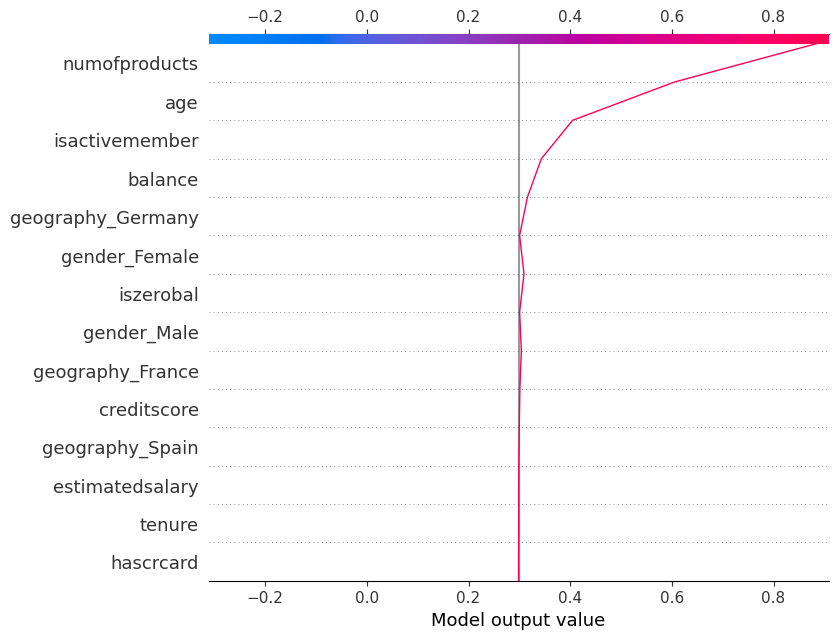

In [102]:
# decision plot

shap.plots.decision(shap_values=row_shap_values.values, base_value=row_shap_values.base_values,
                    feature_names=X_test.columns.tolist())

**Batch Data Plots**

In [103]:
# sample of test data
sample_batch_data = X_test.sample(3)

# shap_values
batch_shap_values = explainer(sample_batch_data)

In [104]:
batch_shap_values.shape

(3, 14)

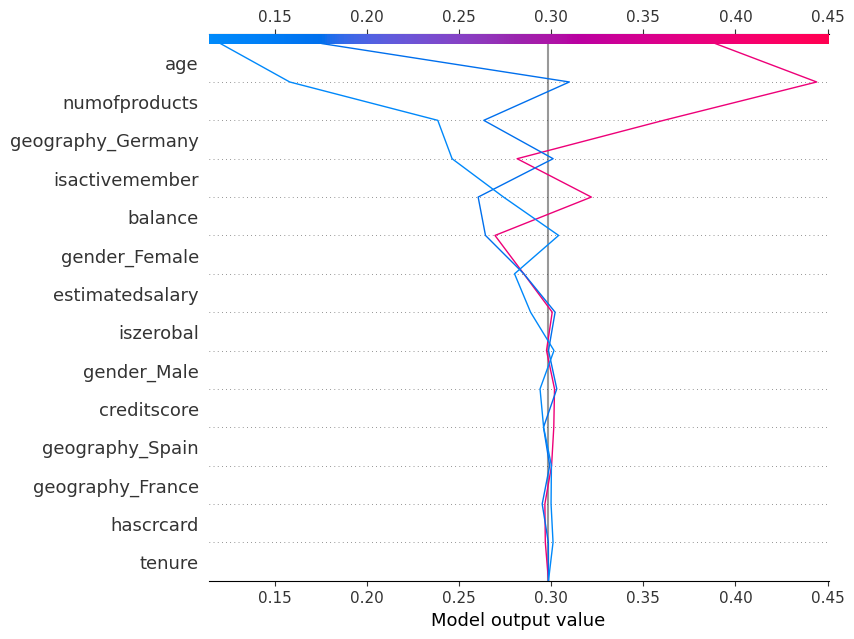

In [105]:
# decision plot

shap.plots.decision(shap_values=batch_shap_values.values, base_value=batch_shap_values.base_values[0],
                    feature_names=X_test.columns.tolist())

# LIME

In [106]:
# test case

test_case_lime = test_case.values.flatten()

In [108]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=da68fec10752f0cd0fa6493100fe31a8a7b7fa1709f954582cd2e2fd43499182
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [109]:
from lime.lime_tabular import LimeTabularExplainer

In [110]:
feature_names = preprocessor.get_feature_names_out().tolist()

In [111]:
preprocessor.get_feature_names_out()

array(['creditscore', 'age', 'balance', 'estimatedsalary',
       'gender_Female', 'gender_Male', 'geography_France',
       'geography_Germany', 'geography_Spain', 'tenure', 'numofproducts',
       'hascrcard', 'isactivemember', 'iszerobal'], dtype=object)

In [112]:
# list of index numbers of categorical features in data

categorical_features = [4, 5, 6, 7, 8, 11, 12, 13]

In [113]:
# create the explainer

lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    mode="classification",
    feature_names=feature_names,
    categorical_features=categorical_features
)

In [114]:
# create an explanation

lime_explanation = lime_explainer.explain_instance(data_row=test_case_lime,
                                                   predict_fn=model.predict_proba)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [115]:
# view my explanations --> as a list

lime_explanation.as_list()

[('numofproducts > 2.00', 0.3451394266730144),
 ('age > 0.35', 0.2934957685587913),
 ('isactivemember=0', 0.11236944827370038),
 ('gender_Female=0', -0.04632541006772354),
 ('geography_Germany=1', 0.027314142544243903),
 ('iszerobal=0', 0.017046766869477745),
 ('geography_Spain=0', 0.011942055279806152),
 ('geography_France=0', 0.010676047028686032),
 ('estimatedsalary <= 0.26', 0.009626106341866695),
 ('gender_Male=1', -0.009160962353987234)]

In [116]:
from IPython.core.display import HTML

In [117]:
display(HTML(lime_explanation.as_html()))